In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor

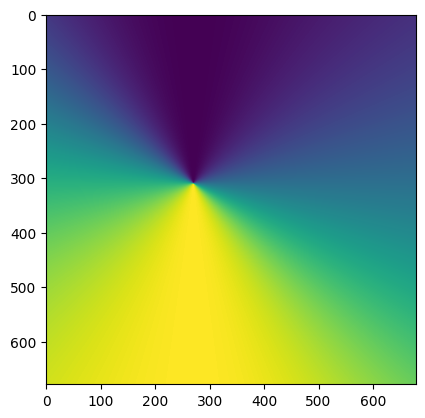

In [4]:
#checking the vaildity of the source plane map
import copy
import matplotlib.pyplot as plt
%matplotlib inline


# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size, 679), np.linspace(0, size, 679))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)
plt.imshow(alpha_y_2d)

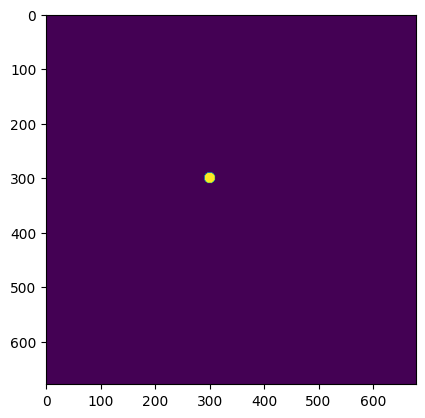

In [5]:
# make a subpixel circle
def circle(radius, center):
    x = np.linspace(0, size, 679)
    y = np.linspace(0, size, 679)
    x, y = np.meshgrid(x, y)
    return (x - center[0])**2 + (y - center[1])**2 < radius**2

plt.imshow(circle(10, (300, 300)))